In [1]:
from __Detection.detection_api import DetectionAPI
from __Tracking.tracking_api import TrackerAPI
from tools.homo_graphy import PlanProjector
from tools.stream import StreamCCTV
from matplotlib import pyplot as plt
import cv2

In [2]:
class Args:
    track_thresh = 0.5
    match_thresh = 0.5
    track_buffer = 60
    mot20 = False
    cpu_workers = 10   # 듀얼 CPU 적극 활용
    chunk_sec   = 10.0 # 15~30초 권장
args = Args()

In [3]:
detector = DetectionAPI()
tracker = TrackerAPI(args=args, detector=detector)
cam1 = StreamCCTV(
            url="rtsp://210.99.70.120:1935/live/cctv001.stream",
            transport="tcp",
            max_width=1920
                ).start()
cam1.wait_ready(2.0)

Loads checkpoint by local backend from path: /workspace/PretrainedModel_by_JeonYT/vehicle/epoch_54.pth
Loads checkpoint by local backend from path: /workspace/PretrainedModel_by_JeonYT/worker/epoch_100.pth


False

In [4]:
# 1) 도면 + (선택) H 로드
plan_path = "/workspace/assets/25082_homograph_coordinate-plane.jpg"
plan_pts  = [
            (3588, 412),    #point1
            (3588, 1036),   #point2
            (3588, 1657),   #point3
            (2225, 412),    #point4
            (2225, 1036),   #point5
            (2225, 1657),   #point6
            (861, 412),     #point7
            (861, 1036),    #point8
            (861, 1657),    #point9
             ]

### Cam#1

In [5]:
# 2) 대응점으로 H 추정 (리스트 안에 '튜플' 형태) --> 예시 나중에 바꿔야함
projector1 = PlanProjector(plan_path, trail_len=60, trail_ttl=30, line_thickness=4, point_radius=6)
cam1_pts = [
    (1390, 521),  #point1
    (1618, 552),  #point2
    (1784, 578),  #point3
    (1112, 564),  #point4
    (1434,620),   #point5
    (1709,668),   #point6
    (481,651),    #point7
    (852,809),    #point8
    (1393,1007)   #point9
    ]
H, mask = projector1.fit_homography(cam1_pts, plan_pts, ransac_thresh=3.0)


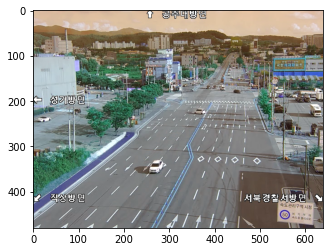

In [7]:
frame = cam1.shoot()
plt.imshow(frame)

/opt/conda/envs/mmyolo/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


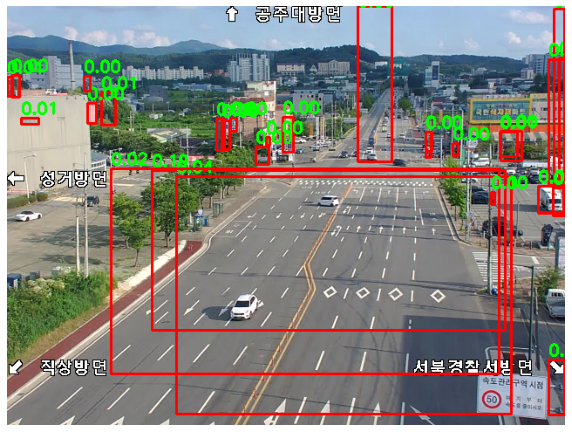

array([[[222, 191, 167],
        [222, 191, 167],
        [222, 191, 167],
        ...,
        [214, 177, 156],
        [214, 177, 156],
        [214, 177, 156]],

       [[222, 191, 167],
        [222, 191, 167],
        [222, 191, 167],
        ...,
        [218, 181, 160],
        [218, 181, 160],
        [218, 181, 160]],

       [[221, 191, 164],
        [221, 191, 164],
        [221, 191, 164],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[125, 126, 131],
        [121, 122, 127],
        [119, 122, 127],
        ...,
        [135, 129, 132],
        [136, 127, 138],
        [128, 119, 130]],

       [[122, 123, 128],
        [115, 116, 121],
        [107, 112, 118],
        ...,
        [132, 126, 129],
        [133, 124, 135],
        [125, 116, 127]],

       [[129, 130, 135],
        [137, 138, 143],
        [172, 177, 183],
        ...,
        [129, 123, 126],
        [130, 121, 132],
        [122, 113, 124]]

In [8]:
from tools.visual_tools import show_detections
result = detector.detect(frame)
show_detections(
    image_or_path=frame, 
    detections_result=result, 
    score_thr=0.0, 
    save_path=None
    )

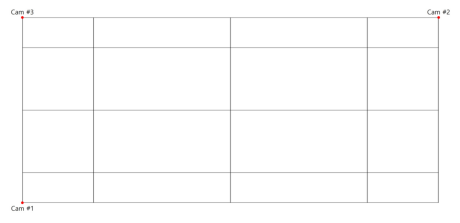

In [ ]:
cam1_tracklets = tracker.track_image(frame)
projected, canvas = projector1.projection(
    dets_frame=cam1_tracklets,     # [{"id","bbox"(tlwh/xyxy),"score"}, ...]
    mode="bottom_center",     # 'center' / 'bottom_center' / 'corners'
    draw=True                 # 도면 위에 바로 그림
)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
cam1.stop()